# Piezo-electro sensor

- Nicolò Montalti (S4947231)
- ...

In [29]:
import numpy as np                      # used for array manipulation
from scipy.integrate import solve_ivp   # used to solve differential equation
from scipy.signal import find_peaks     # used to analyze the result
from scipy import fft                   # fourier transform
from matplotlib import pyplot as plt    # plotting
from ipywidgets import widgets          # interactive widgets

# display plots in the notebook
%matplotlib inline

## Differential equation
We know that the ideal spring euqation $F = kx$ can be improved adding a non-linear component $\alpha kx^3$. So for the static case, without friction we have
$$
 F = kx + \alpha k^3x^3 
$$
Adding friction, proportional to $\dot{x}$ with a coefficient $\lambda$, and inertia we have
$$
    F = kx + \alpha k^3x^3 + \lambda \dot{x} + m \ddot{x}
$$
Since $q = Kx$
$$
F = \frac{k}{K} q + \alpha\frac{k^3}{K^3}q^3 + \frac{\lambda}{K}\dot{q} + \frac{m}{K}\ddot{q} = \frac{m}{K} \left( \frac{k}{m} q + \alpha\frac{k}{m}\frac{k^2}{K^2}q^3 + \frac{\lambda}{m}\dot{q} + \ddot{q} \right)
$$
Using $\omega_0 = \sqrt{k/m}$, $\xi = \lambda/2\sqrt{km}$ and $d = K / k $ we get
$$
F = \frac{1}{d \omega_0^2}\left[ \ddot{q} + 2\xi\omega\dot{q} + \omega_0^2 \left(1 + \alpha d^2 q^2 \right) q \right]
$$
which, in the linear case ($\alpha = 0$), reads
$$
F = \frac{1}{d \omega_0^2}\left[ \ddot{q} + 2\xi\omega\dot{q} + \omega_0^2 q \right]
$$

## Solving the differential equation
We can know define the functions necessary to solve the differential equation

In [2]:
def force(t, omega):
    '''
    This function computes the force with which the piezo-electro sensor is stimulated.
    It is a harmonic force of amplitude 1 and angular frequency omega.

    Parameters:
    -----------
    t: time [s]
    omega: angular frequency [s^-1]

    Returns:
    --------
    (float) sin(omega*t)
    '''
    return np.sin(omega*t)

def q_vector_derivative(t, q_vector, omega, omega_0, xi, d, alpha):
    '''
    This function 

    Parameters:
    -----------
    t: time [s]
    q_vector: numpy array of the form (q,q'), where q is the charge [C]
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]

    Returns:
    --------
    (numpy array) derivative of [q,q']
    '''

    q0 = q_vector[0]
    q1 = q_vector[1]
    q0_d = q1
    q1_d = d * omega_0**2 * force(t, omega) - 2 * xi * omega_0 * q1 - omega_0**2 * (1 + alpha * d**2 * q0**2) * q0

    return np.array([q0_d, q1_d])

def solve_differential_equation(periods, initial_condition, omega, omega_0=1, xi=1, d=1, alpha=0):
    '''
    Solve the differential equation q_vector(t)' = q_vector_derivative(t, omega, omega_0, xi, d, alpha)
    
    Parameters:
    ------------
    time_points: array-like sequence of time instants where to solve the equation
    inital_condition: array with the inistal condition [q_init, q_init']
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]
    alpha: non-linear factor [N^-2]

    Returns:
    --------
    (time_points, q_vector_solution)
    '''

    total_time = periods * 2 * np.pi / omega
    time_points = np.linspace(0, total_time, 1000)

    ode_solution = solve_ivp(q_vector_derivative, (0, total_time),
                             initial_condition, t_eval=time_points,
                             args=(omega, omega_0, xi, d, alpha))
                            
    return (ode_solution.t, ode_solution.y)

## Results
### Linear case
We first investigate the linear case ($\alpha = 0$). In particular we are interested in the dependence of the solution on $\omega$ and $\xi$

In [112]:
def plot_time_dependence(omega, xi):
    '''
    Makes three plots given the values of omega and xi:
        - the first plot shows the dependance of charge on time over a 20 periods;
        - the second one is a phase diagram;
        - the third one shows the fourier transform of the first plot, plus the value of omega.    
    '''
    periods = 20
    initial_condition = np.array([0,0])
    t, y = solve_differential_equation(periods, initial_condition, omega=omega, xi=xi)
    
    fig = plt.figure(figsize=(16,4))
    axs = fig.subplots(1,3)
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Charge [C]')
    axs[0].plot(t, y[0])
    axs[0].grid(True)
    axs[0].set_title('Time evolutionover 20 periods')
    axs[0].set_ylim(-1.5, 1.5)

    axs[1].plot(y[0], y[1])
    axs[1].grid(True)
    axs[1].set_title('Phase space')
    axs[1].set_xlabel(r'$q$ [C]')
    axs[1].set_ylabel(r'$\dot{q}$ [C/s]')

    peaks, _ = find_peaks(y[0])
    #print((peaks))
    axs[0].plot(t[peaks], y[0,peaks], color='tab:orange')

    N = t.size
    delta_t = t[1]-t[0]
    signal_fft = fft.fft(y[0])
    frequencies = fft.fftfreq(N, delta_t)
    axs[2].set_xlim(0, 2*np.pi)
    axs[2].plot(frequencies[:N//2]*2*np.pi, np.abs(signal_fft[: N//2]), label='FFT (charge)')
    axs[2].axvline(omega, color='tab:orange', label=r'$\omega$ (force)')
    axs[2].grid(True)
    axs[2].set_title('Fourier transform')
    axs[2].set_xlabel(r'$\omega$ [$s^{-1}$]')
    axs[2].set_ylabel('Amplitude (a.u.)')
    axs[2].legend()

    fig.tight_layout()
    

# With the following widgets it's possible to interact with the plots modifying the values of omega and xi.
widget_omega = widgets.FloatSlider(np.pi, min=0.01, max=np.pi*2, description='Omega')
widget_xi = widgets.FloatSlider(1, min=0, max=2, description='Xi')

widgets.interact(plot_time_dependence, omega = widget_omega, xi=widget_xi)

interactive(children=(FloatSlider(value=3.141592653589793, description='Omega', max=6.283185307179586, min=0.0…

<function __main__.plot_time_dependence(omega, xi)>

Varying $\omega$ and $\xi$ in the prevoius plots,we found out...

AttributeError: 'Figure' object has no attribute 'title'

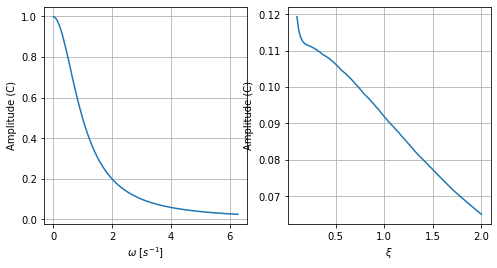

In [127]:
N = 100
omegas = np.linspace(0.01, 2*np.pi, N)
xis = np.linspace(0.1, 2, N)
amplitude_omegas = np.ones(N)
amplitude_xis = np.ones(N)

def solve_for_omega(omega):
    periods = 20
    _, y = solve_differential_equation(periods, np.array([0,0]), omega=omega)
    peaks, _ = find_peaks(y[0])
    return y[0,peaks[-1]]

def solve_for_xi(xi):
    periods = 20
    _, y = solve_differential_equation(periods, np.array([0,0]), omega=np.pi, xi=xi)
    peaks, _ = find_peaks(y[0])
    return y[0, peaks[-1]]

amplitude_omegas = np.array([solve_for_omega(omega) for omega in omegas])
amplitude_xis = np.array([solve_for_xi(xi) for xi in xis])

fig = plt.figure(figsize=(8, 4))
axs = fig.subplots(1,2)

axs[0].plot(omegas, amplitude_omegas)
axs[0].set_xlabel(r'$\omega$ [$s^{-1}$]')
axs[0].set_ylabel('Amplitude (C)')
axs[0].grid(True)

axs[1].plot(xis, amplitude_xis)
axs[1].set_xlabel(r'$\xi$')
axs[1].set_ylabel('Amplitude (C)')
axs[1].grid(True)

fig.title(r'Dependence of the amplitude after 20 periods on $\omega$ ans $\xi$')
fig.tight_layout()